In [241]:
from IPython.display import display, Image

In [242]:
# The talk from now on may be a bit complex.

In [243]:
# 1. Encoder - Decoder Architecture
# 2. Attention
# 3. Self-Attention

What is Encoder and Decoder?


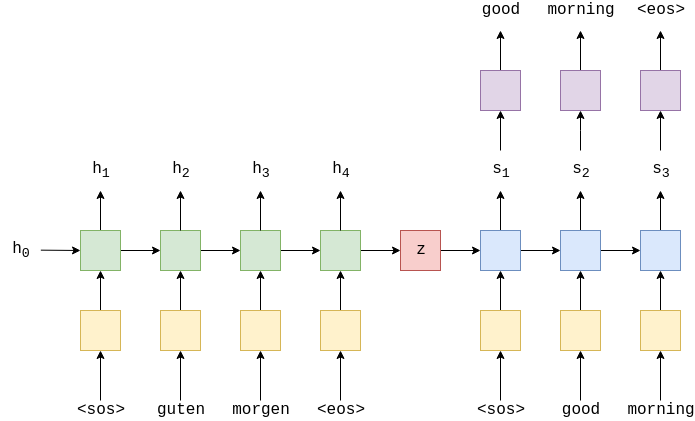

In [244]:
print("What is Encoder and Decoder?")
with open('./encdec1.png','rb') as file:
    display(Image(file.read()))

Do you remember the concept of attention from my session ?


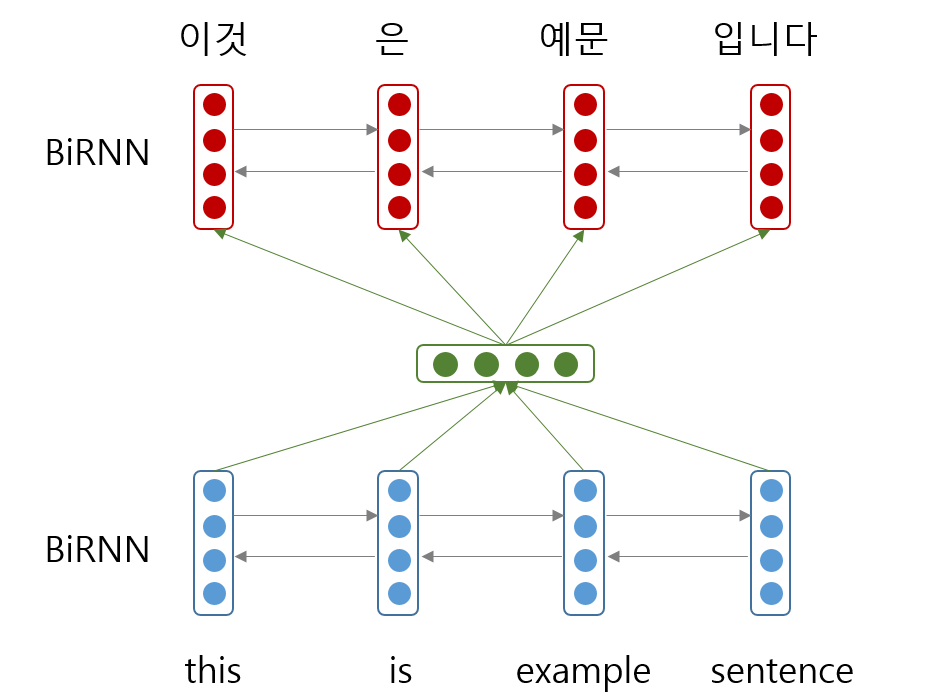

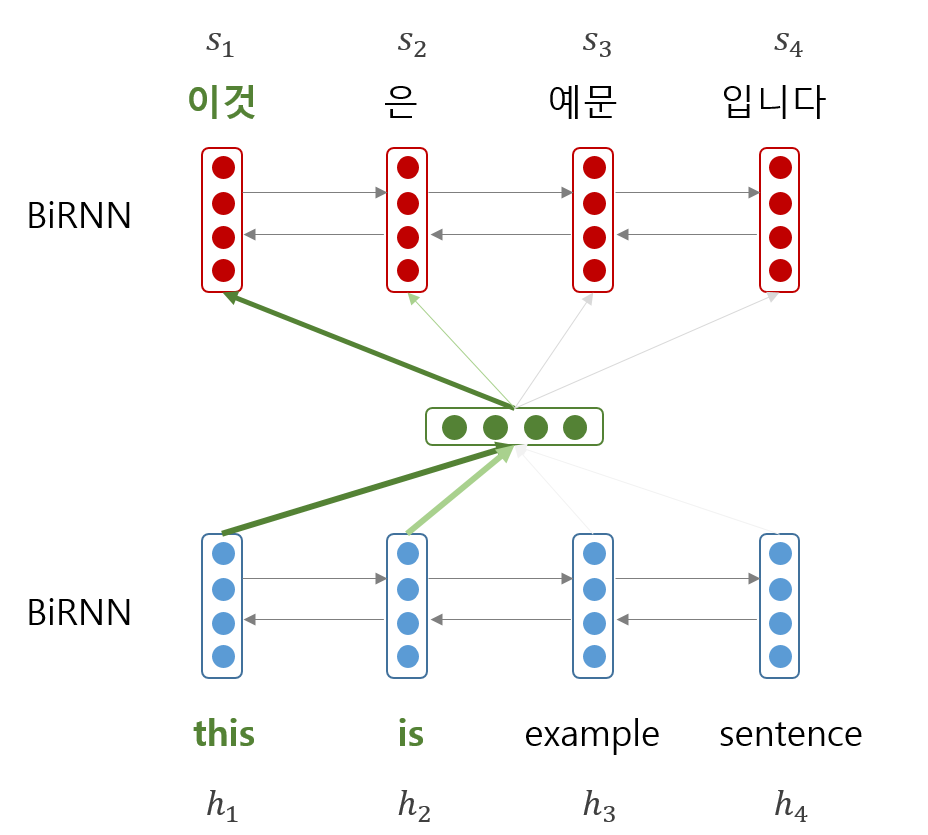

In [245]:
print("Do you remember the concept of attention from my session ?")
with open('./noattention.png','rb') as file:
    display(Image(file.read()))
with open('./yesattention.png','rb') as file:
    display(Image(file.read()))

Applying the concept above, we can end up with this picture.


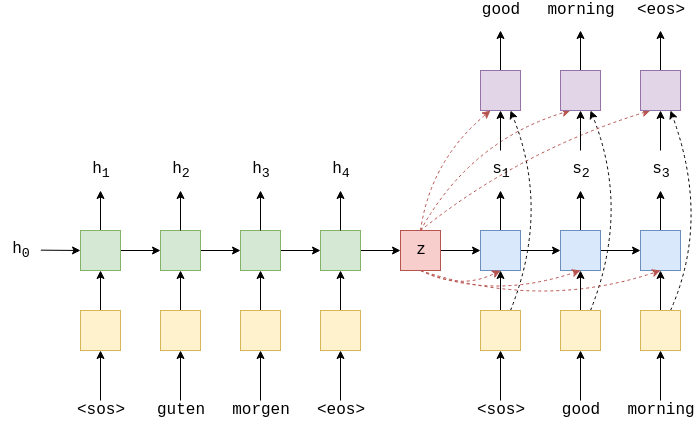

In [246]:
print("Applying the concept above, we can end up with this picture.")
with open('./encdec2.png','rb') as file:
    display(Image(file.read()))

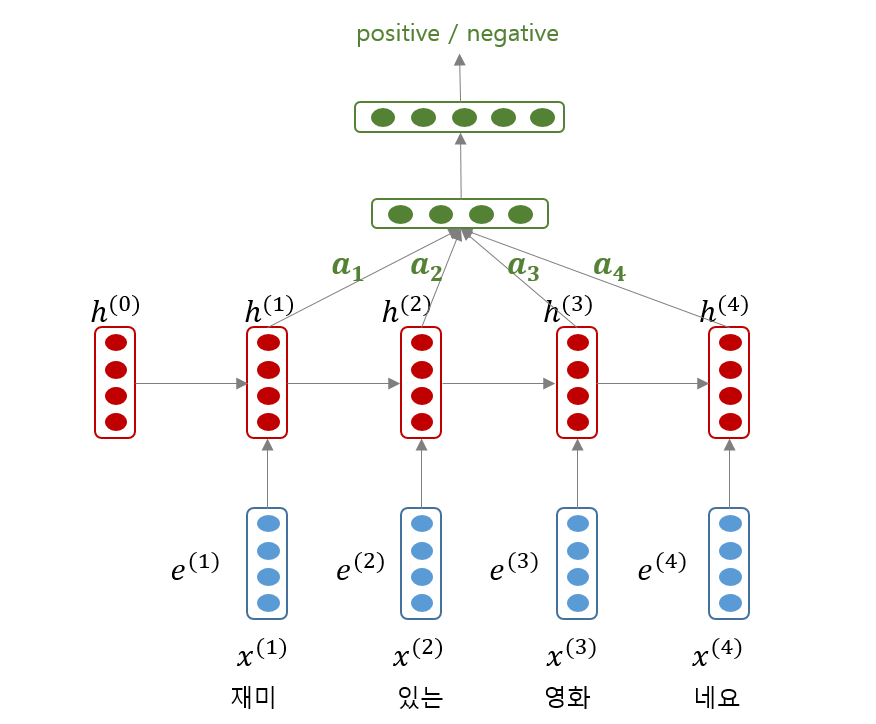

In [247]:
with open('./yesattention2.png','rb') as file:
    display(Image(file.read()))

In [248]:
%pip install torchtext
%pip install spacy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [249]:
# Necessary libraries, seed, ...

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# In terminal,
# python3 -m spacy download en
# python3 -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [250]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [251]:
with open('./encpic.png','rb') as file:
    display(Image(file.read()))

In [252]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(batch_first=True, input_size=emb_dim, hidden_size=enc_hid_dim, num_layers=3)
        self.fc = nn.Linear(enc_hid_dim, dec_hid_dim)

    def forward(self, features):
        embedded_features = self.embedding(features)
        outputs, hidden = self.rnn(embedded_features)
        hidden = torch.tanh(self.fc(hidden[-1, :, :])) # [batch, seq size, dec hid dim]
        return outputs, hidden

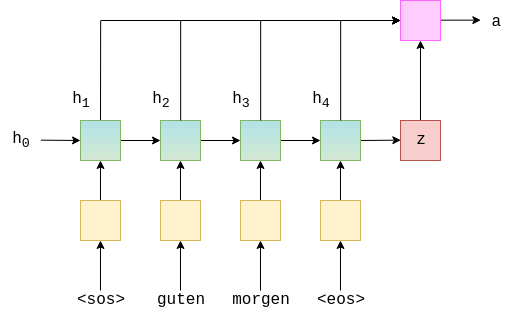

In [253]:
with open('./attnpic.png','rb') as file:
    display(Image(file.read()))

In [254]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        seq_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        energy = torch.tanh(
            self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

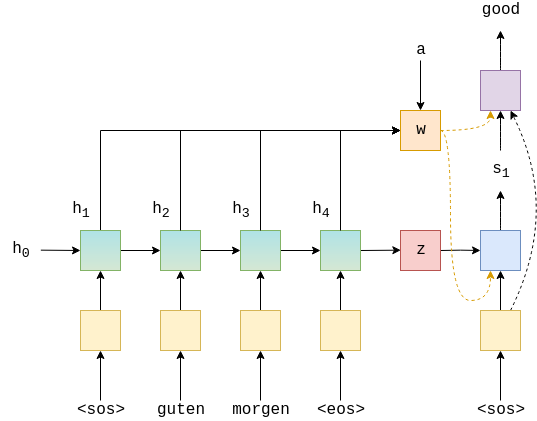

In [255]:
with open('./decpic.png','rb') as file:
    display(Image(file.read()))

In [256]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(batch_first=True, input_size=enc_hid_dim + emb_dim, hidden_size=dec_hid_dim)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # encoder outputs -> [batch, seq len, dec hid dim]
        input = input.unsqueeze(1) # [batch, 1]
        embedded_decoder_input = self.embedding(input) # [batch, 1, embedding dim]
        a = self.attention(hidden, encoder_outputs) # [batch, seq len]
        a = a.unsqueeze(1) # [batch, 1, seq len]
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, dec hid dim]
        rnn_input = torch.cat((embedded_decoder_input, weighted), dim=2) # [batch, 1,  embedding dim + dec hid dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # [batch, 1, dec_hid_dim] , [1, batch, enc hid dim]
        embedded_decoder_input = embedded_decoder_input.squeeze(1) # [batch, enc hid dim]
        output = output.squeeze(1) # [batch, dec hid dim]
        weighted = weighted.squeeze(1) # [batch, dec hid dim]
        prediction = self.fc_out(torch.cat((output, weighted, embedded_decoder_input), dim=1))
        return prediction, hidden.squeeze(0)

In [257]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0] # First input to decoder is <sos> token

        for t in range(1, trg_len):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)

            # place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            input = top1

        return outputs

In [258]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attn)
model = Seq2Seq(enc, dec)

optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [260]:
for batch in train_iterator:
    src = batch.src.permute(1,0)
    trg = batch.trg.permute(1,0)

    optimizer.zero_grad()
    output = model(src, trg)
    print(output)
    raise AssertionError

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0534,  0.1997, -0.2874,  ...,  0.0301,  0.0534, -0.1493],
         [ 0.0472,  0.1973, -0.2816,  ...,  0.0511,  0.0606, -0.1550],
         [ 0.0640,  0.1800, -0.2952,  ...,  0.0131,  0.0515, -0.1553],
         ...,
         [ 0.0574,  0.1744, -0.3042,  ...,  0.0024,  0.0480, -0.1443],
         [ 0.0546,  0.1921, -0.2936,  ...,  0.0186,  0.0504, -0.1472],
         [ 0.0555,  0.1915, -0.2873,  ...,  0.0428,  0.0435, -0.1553]],

        [[-0.1785,  0.7023, -0.2923,  ..., -0.0743,  0.4248,  0.1991],
         [-0.4674, -0.3143, -0.1848,  ...,  0

AssertionError: 